**Objective:**

**Build a scalable ETL pipeline using PySpark to process raw server log files, extract relevant fields, and compute error and traffic statistics.**

**Step 1: Setup PySpark Environmentb**

Installing and configuring PySpark in Google Colab.

In [10]:
# 1. Install Java & Spark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar -xzf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

# 2. Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

# 3. Initialize findspark and start Spark session
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LogDataETL") \
    .getOrCreate()

spark


**Step 2: Create Sample Log File**

Creating a dummy server log dataset (you can replace it with actual logs later).

In [17]:
# Recreate the file to ensure it's present
sample_logs = """
127.0.0.1 - - [08/May/2025:14:12:15 +0000] "GET /home HTTP/1.1" 200 2048
192.168.0.1 - - [08/May/2025:14:13:22 +0000] "POST /login HTTP/1.1" 302 1024
10.0.0.1 - - [08/May/2025:14:14:33 +0000] "GET /dashboard HTTP/1.1" 200 4096
172.16.0.1 - - [08/May/2025:14:15:40 +0000] "GET /api/data HTTP/1.1" 500 512
"""
with open("sample_logs.log", "w") as f:
    f.write(sample_logs.strip())

**Step 3: Load Log Data into Spark**

Loading unstructured log data into a Spark DataFrame.

In [18]:
log_df = spark.read.text("sample_logs.log")
log_df.show(truncate=False)

+----------------------------------------------------------------------------+
|value                                                                       |
+----------------------------------------------------------------------------+
|127.0.0.1 - - [08/May/2025:14:12:15 +0000] "GET /home HTTP/1.1" 200 2048    |
|192.168.0.1 - - [08/May/2025:14:13:22 +0000] "POST /login HTTP/1.1" 302 1024|
|10.0.0.1 - - [08/May/2025:14:14:33 +0000] "GET /dashboard HTTP/1.1" 200 4096|
|172.16.0.1 - - [08/May/2025:14:15:40 +0000] "GET /api/data HTTP/1.1" 500 512|
+----------------------------------------------------------------------------+



**Step 4: Parse the Log Data Using regexp_extract**

Extract structured information from raw log strings using regex. This avoids UDFs and serialization issues.

In [19]:
from pyspark.sql.functions import regexp_extract, col

# Define regex patterns
ip_pattern = r'^(\S+)'                            # IP address
timestamp_pattern = r'\[(.*?)\]'                 # Timestamp
method_pattern = r'\"(\S+)'                      # HTTP Method
url_pattern = r'\"(?:GET|POST) (\S+)'            # Requested URL
status_code_pattern = r'\" (\d{3})'              # Status Code
response_size_pattern = r' (\d+)$'              # Response size (if available)

# Parse the fields using regexp_extract
parsed_df = log_df.withColumn("ip", regexp_extract(col("value"), ip_pattern, 1)) \
    .withColumn("timestamp", regexp_extract(col("value"), timestamp_pattern, 1)) \
    .withColumn("method", regexp_extract(col("value"), method_pattern, 1)) \
    .withColumn("url", regexp_extract(col("value"), url_pattern, 1)) \
    .withColumn("status_code", regexp_extract(col("value"), status_code_pattern, 1)) \
    .withColumn("response_size", regexp_extract(col("value"), response_size_pattern, 1))

parsed_df.show(truncate=False)

+----------------------------------------------------------------------------+-----------+--------------------------+------+----------+-----------+-------------+
|value                                                                       |ip         |timestamp                 |method|url       |status_code|response_size|
+----------------------------------------------------------------------------+-----------+--------------------------+------+----------+-----------+-------------+
|127.0.0.1 - - [08/May/2025:14:12:15 +0000] "GET /home HTTP/1.1" 200 2048    |127.0.0.1  |08/May/2025:14:12:15 +0000|GET   |/home     |200        |2048         |
|192.168.0.1 - - [08/May/2025:14:13:22 +0000] "POST /login HTTP/1.1" 302 1024|192.168.0.1|08/May/2025:14:13:22 +0000|POST  |/login    |302        |1024         |
|10.0.0.1 - - [08/May/2025:14:14:33 +0000] "GET /dashboard HTTP/1.1" 200 4096|10.0.0.1   |08/May/2025:14:14:33 +0000|GET   |/dashboard|200        |4096         |
|172.16.0.1 - - [08/May/2025

**Step 5: Perform Basic Aggregations**

Compute common metrics like request count, error count, and top URLs.

In [20]:
from pyspark.sql.functions import count, desc

# Count total requests
parsed_df.select(count("*").alias("Total Requests")).show()

# Count requests by status code
parsed_df.groupBy("status_code").count().orderBy(desc("count")).show()

# Top requested URLs
parsed_df.groupBy("url").count().orderBy(desc("count")).show(5)

+--------------+
|Total Requests|
+--------------+
|             4|
+--------------+

+-----------+-----+
|status_code|count|
+-----------+-----+
|        200|    2|
|        302|    1|
|        500|    1|
+-----------+-----+

+----------+-----+
|       url|count|
+----------+-----+
|    /login|    1|
|     /home|    1|
|/dashboard|    1|
| /api/data|    1|
+----------+-----+



**Step 6: Save Clean Data to Parquet**

Save parsed and structured log data for downstream analytics.

In [21]:
parsed_df.write.mode("overwrite").parquet("clean_logs_parquet/")

**Part 1: Visualize Metrics Using Seaborn/Matplotlib**

We’ll convert the cleaned Spark DataFrame to Pandas to plot with seaborn or matplotlib.

**Step 7: Load cleaned data from Parquet and convert to Pandas**

In [24]:
# Load Parquet data
clean_df = spark.read.parquet("clean_logs_parquet")

# Convert to Pandas for visualization
pdf = clean_df.toPandas()

**Step 8: Plot status code distribution**

<ipython-input-25-9461b2a4816a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="status_code", data=pdf, palette="viridis")


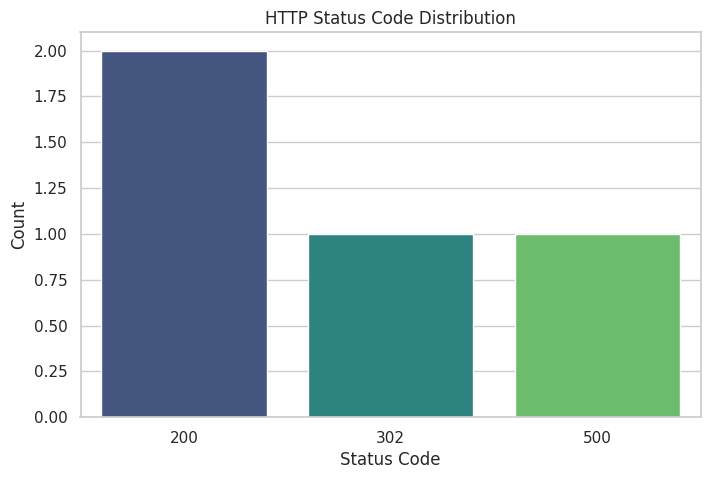

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(x="status_code", data=pdf, palette="viridis")
plt.title("HTTP Status Code Distribution")
plt.xlabel("Status Code")
plt.ylabel("Count")
plt.show()